# Facial Expression Recognition

The FER-2013 dataset, short for Facial Expression Recognition 2013 dataset, created for the Facial Expression Recognition Challenge, consists of 35887 images with a resolution of 48x48 pixels, 28709 images for training and 7178 images for testing, depicting facial expressions corresponding to seven different emotion classes: Angry, Disgust, Fear, Happy, Sad, Surprise and Neutral.  This dataset is often used to train and evaluate machine learning models for facial expression recognition tasks.

## Install Packages and Dataset

In [1]:
!git clone https://github.com/kemalkilicaslan/Facial_Expression_Recognition.git
!pip install timm

Cloning into 'Facial_Expression_Recognition'...
remote: Enumerating objects: 34063, done.
remote: Total 34063 (delta 0), reused 0 (delta 0), pack-reused 34063
Receiving objects: 100% (34063/34063), 67.10 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (35898/35898), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.6 MB/s eta 0:00:00


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Configurations

In [3]:
train_img_folder_path = '/content/Facial_Expression_Recognition/train'
test_img_folder_path = '/content/Facial_Expression_Recognition/test'

In [4]:
lr = 0.001
batch_size=32
epochs=20
device = 'cuda'
model_name='efficientnet'

## Load Dataset

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [6]:
train_aug = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() # PIL / numpy arr -> torch tensor -> (h, w,c) -> (c, h, w)
])

test_aug= T.Compose([
    T.ToTensor()
])

In [7]:
trainset = ImageFolder(train_img_folder_path, transform = train_aug)
testset = ImageFolder(test_img_folder_path, transform = test_aug)

print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in testset : {len(testset)}")

Total no. of examples in trainset : 28709
Total no. of examples in testset : 7178


In [8]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

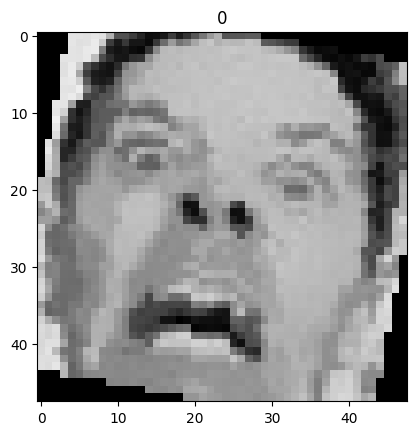

In [9]:
image, label = trainset[40]
plt.imshow(image.permute(1,2,0)) #(h, w, c)
plt.title(label)

Text(0.5, 1.0, '0')

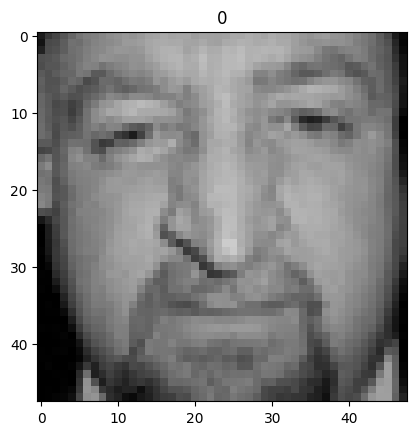

In [10]:
image, label = testset[40]
plt.imshow(image.permute(1,2,0)) #(h, w, c)
plt.title(label)

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size, batch_size)

print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in testloader : {len(testloader)}")

Total no. of batches in trainloader : 898
Total no. of batches in testloader : 225


In [13]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


## Create Model

In [14]:
import timm
from torch import nn

In [15]:
class FaceRecognitionModel(nn.Module):

  def __init__(self):
    super(FaceRecognitionModel, self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)

  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits

In [16]:
model = FaceRecognitionModel()
model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Create Train and Eval Function

In [17]:
from tqdm import tqdm

In [18]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
def train_func(model, dataloader, optimizer, epoch):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "epoch" + "[train]" + str(epoch + 1) +  "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t + 1)), 'acc' : '%6f' %float(total_acc / (t + 1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

In [20]:
def eval_func(model, dataloader, epoch):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "epoch" + "[train]" + str(epoch + 1) +  "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t + 1)), 'acc' : '%6f' %float(total_acc / (t + 1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

## Model Training

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [22]:
best_test_loss = np.Inf

for i in range(epochs):
  train_loss, train_acc = train_func(model, trainloader, optimizer, i)
  test_loss, test_acc = eval_func(model, testloader, i)

  if test_loss < best_test_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print("Saved best-weights")
    best_test_loss = test_loss

epoch[train]1/20: 100%|██████████| 225/225 [00:06<00:00, 35.25it/s, loss=1.361929, acc=0.473222]


Saved best-weights


epoch[train]2/20: 100%|██████████| 225/225 [00:07<00:00, 31.86it/s, loss=1.169665, acc=0.551556]


Saved best-weights


epoch[train]3/20: 100%|██████████| 225/225 [00:06<00:00, 35.52it/s, loss=1.167089, acc=0.560250]


Saved best-weights


epoch[train]4/20: 100%|██████████| 225/225 [00:07<00:00, 31.19it/s, loss=1.124356, acc=0.575806]


Saved best-weights


epoch[train]5/20: 100%|██████████| 225/225 [00:06<00:00, 34.90it/s, loss=1.103011, acc=0.590722]


Saved best-weights


epoch[train]6/20: 100%|██████████| 225/225 [00:07<00:00, 31.27it/s, loss=1.075633, acc=0.594278]


Saved best-weights


epoch[train]7/20: 100%|██████████| 225/225 [00:06<00:00, 34.63it/s, loss=1.037396, acc=0.616028]


Saved best-weights


epoch[train]11/20: 100%|██████████| 225/225 [00:07<00:00, 31.47it/s, loss=1.027363, acc=0.627861]


Saved best-weights


epoch[train]12/20: 100%|██████████| 225/225 [00:06<00:00, 35.34it/s, loss=1.001174, acc=0.634056]


Saved best-weights


epoch[train]13/20: 100%|██████████| 225/225 [00:07<00:00, 31.66it/s, loss=0.992073, acc=0.637111]


Saved best-weights


epoch[train]19/20: 100%|██████████| 225/225 [00:06<00:00, 36.04it/s, loss=0.991358, acc=0.654111]


Saved best-weights


epoch[train]20/20: 100%|██████████| 225/225 [00:07<00:00, 31.96it/s, loss=1.070224, acc=0.633722]


## Result

In [23]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

True Label: angry, Predicted Label: disgust, Predicted Probability: 0.7471802830696106
True Label: disgust, Predicted Label: disgust, Predicted Probability: 0.9846369028091431
True Label: fear, Predicted Label: fear, Predicted Probability: 0.5837821364402771
True Label: happy, Predicted Label: happy, Predicted Probability: 0.9693137407302856
True Label: neutral, Predicted Label: happy, Predicted Probability: 0.8458672761917114
True Label: sad, Predicted Label: angry, Predicted Probability: 0.6017364263534546
True Label: surprise, Predicted Label: surprise, Predicted Probability: 0.6609428524971008


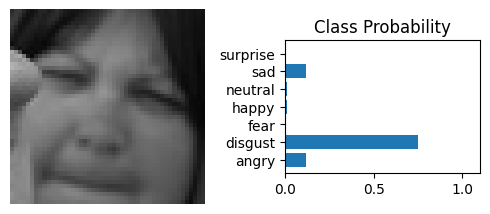

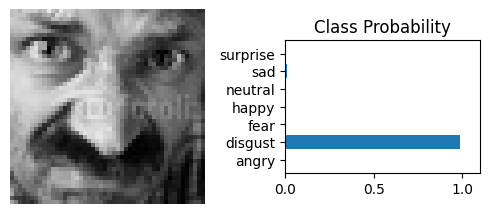

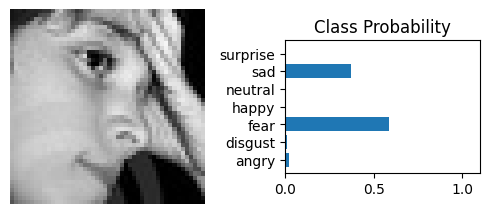

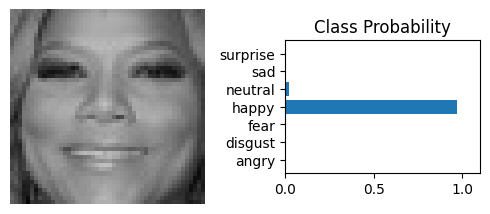

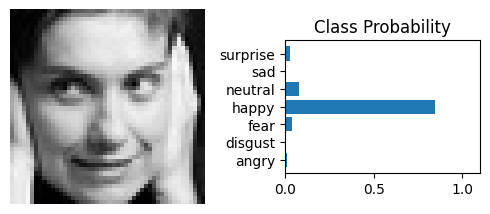

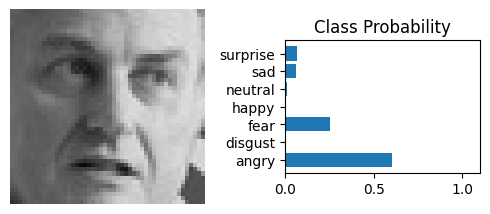

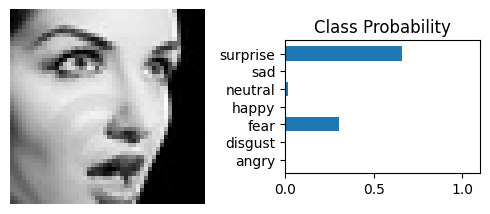

In [24]:
def predict(model, dataloader, num_class=7):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        logits = model(images)
        ps = torch.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)

    for i in range(num_class):
        for j, image in enumerate(images):
            label = labels[j].item()
            predicted_class = top_class[j].item()
            predicted_prob = top_p[j].item()

            predicted_label = trainset.classes[predicted_class]
            true_label = trainset.classes[label]

            if true_label == trainset.classes[i]:
                print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Predicted Probability: {predicted_prob}")
                view_classify(image.cpu(), ps[j])
                break  # Show only the first prediction for each class

# Example usage
predict(model, testloader, num_class=7)